# TPXO energy flux divergence ($\nabla\cdot$P)

### $\nabla\cdot P = \rho_0g \nabla \cdot \bigl< \textbf{U}\eta \bigr>$

#### In spherical coordinate, the divergence of vector $\mathbf{A} = A_r \hat{r} + A_\theta \hat{\theta} + A_\phi \hat{\phi}$

#### $\nabla \cdot \mathbf{A} = \frac{1}{r^2} \frac{\partial}{\partial r} (r^2 A_r) + \frac{1}{r \sin \theta} \frac{\partial}{\partial \theta} (A_\theta \sin \theta) + \frac{1}{r \sin \theta} \frac{\partial A_\phi}{\partial \phi}$

#### Area of the grid cell $dS =  r^2 \sin \theta \, d\theta \, d\phi$

#### $\theta = \frac{\pi}{2} - \text{lat}$, $\phi=\text{lon}$

#### $\sin \theta = \cos(lat)$, $A_\theta=-vH \eta$, $A_\phi=uH \eta$,

#### So $\nabla \cdot \bigl< \textbf{U}\eta \bigr> = \frac{1}{r \cos (\text{lat})} \frac{\partial}{-\partial \text{lat}} (-vH \eta \cos (\text{lat})) + \frac{1}{r \cos (\text{lat})} \frac{\partial (uH \eta)}{\partial \text{lon}}$

#### $dS =  -r^2 \cos (\text{lat}) \, d(\text{lat}) \, d(\text{lon})$

In [1]:
%matplotlib inline
import time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

In [2]:
g = 9.8
nt = 236
rho0 = 1035.0
radius = 6371e+3
t_19cyc = np.arange(nt)

In [3]:
file_stat = '/scratch/nm03/lxy581/mom6/archive/tides_025_global_sigma_SAL_x08/output002/ocean_static.nc'
stat  = xr.open_dataset(file_stat)
depth_025  = stat['deptho']
geolat_025 = stat['geolat']
geolon_025 = stat['geolon']
area_025 = stat['areacello']
fac_dep_025 = xr.where(depth_025 > 1000, 1, np.nan) 
fac_lat_025 = xr.where((geolat_025 < 66) & (geolat_025 > -66), 1, np.nan)
fac_025 = np.array(fac_dep_025) * np.array(fac_lat_025)

In [4]:
lon_z = np.array(stat.geolon)/180 *np.pi
lat_z = np.array(stat.geolat)/180 *np.pi
lon_u = np.array(stat.geolon_u)/180 *np.pi
lat_u = np.array(stat.geolat_u)/180 *np.pi
lon_v = np.array(stat.geolon_v)/180 *np.pi
lat_v = np.array(stat.geolat_v)/180 *np.pi

In [5]:
d = xr.open_dataset('/scratch/nm03/lxy581/mom6/archive/tides_025_global_sigma_SAL_x08/output002/ocean_interior.nc')

time_len = 236

# chunking could probably use some tweaking, mainly to ensure we don't run out of memory on small ARE jobs
elev = d.e.isel(zi=0, time=slice(None, time_len))
elev["time"] = np.arange(len(elev.time)) + 20*24

In [6]:
u = d.uo.isel(zl=0, time=slice(None, time_len))
u["time"] = np.arange(len(u.time)) + 20*24

v = d.vo.isel(zl=0, time=slice(None, time_len))
v["time"] = np.arange(len(v.time)) + 20*24

In [7]:
print(elev.shape)
print(u.shape)
print(v.shape)

(236, 1112, 1440)
(236, 1112, 1441)
(236, 1113, 1440)


### Interpolate $\eta$H to u and v points to calculate $vH\eta$ and $uH\eta$

In [8]:
etaH = np.array(elev) * np.array(depth_025)

In [9]:
start_time = time.time()

ds_elev_z = xr.Dataset(data_vars={"etaH": (('nt','ny','nx'), etaH),
                                 },
                       coords={"lon": (('ny', 'nx'), lon_z), 
                               "lat": (('ny', 'nx'), lat_z)})
ds_grid_u = xr.Dataset({"lat": (["ny","nx"], lat_u),
                        "lon": (["ny","nx"], lon_u)})
ds_grid_v = xr.Dataset({"lat": (["ny","nx"], lat_v),
                        "lon": (["ny","nx"], lon_v)})

print('regridding z to u')
regridder_z2u = xe.Regridder(ds_elev_z, ds_grid_u, "bilinear", extrap_method="inverse_dist")
print('regridding z to v')
regridder_z2v = xe.Regridder(ds_elev_z, ds_grid_v, "bilinear", extrap_method="inverse_dist")

ds_elev_u = regridder_z2u(ds_elev_z)
ds_elev_v = regridder_z2v(ds_elev_z)

end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f seconds! \n" % exe_time)

regridding z to u
regridding z to v
Execution time: 356.6 seconds! 



In [10]:
etaH_u = np.array(ds_elev_u["etaH"]) 
etaH_v = np.array(ds_elev_v["etaH"]) 

### Calculate $\nabla \cdot \bigl< \textbf{U}\eta \bigr> = \frac{1}{r \cos (\text{lat})} \frac{\partial}{\partial \text{lat}} (vH \eta \cos(\text{lat})) + \frac{1}{r \cos (\text{lat})} \frac{\partial (uH \eta)}{\partial \text{lon}}$

1. Calculate the time mean of $vH \eta \sin \theta$ and $uH \eta$

In [11]:
veta = np.nanmean(v * etaH_v * np.cos(lat_v), axis=0) 
ueta = np.nanmean(u * etaH_u, axis=0)

2. Calculate $\frac{\partial}{\partial lat} (vH \eta \sin \theta)$ and $\frac{\partial (uH \eta)}{\partial lon}$

In [12]:
dveta_dlat = g * rho0 * (veta[1:,:] - veta[:-1,:]) / (lat_v[1:,:] - lat_v[:-1,:])
dueta_dlon = g * rho0 * (ueta[:,1:] - ueta[:,:-1]) / (lon_u[:,1:] - lon_u[:,:-1])

3. Calculate $\frac{1}{r \cos (lat)}\frac{\partial}{\partial lat} (vH \eta \sin \theta)$ and $\frac{1}{r \cos (lat)}\frac{\partial (uH \eta)}{\partial lon}$

In [13]:
divP1 = 1/( radius*np.cos(lat_z) ) * dveta_dlat 
divP2 = 1/( radius*np.cos(lat_z) ) * dueta_dlon 

4. Calculate cell area

In [14]:
dlat = np.full((geolat_025.shape),np.nan) 
dlon = np.full((geolat_025.shape),np.nan)
for j in range(geolat_025.shape[0]):
    dlon[j,:] = np.squeeze(lon_v[j+1,:] - lon_u[j,1:])*2
for i in range(geolat_025.shape[1]):
    dlat[:,i] = np.squeeze(lat_u[:,i+1] - lat_v[1:,i])*2

In [15]:
divP = divP1 + divP2
P = divP *1000 

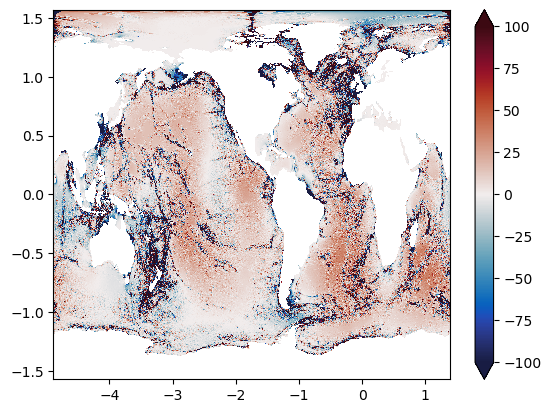

In [16]:
# P.plot(vmin=-100,vmax=100,cmap=cm.cm.balance)
pcm = plt.pcolormesh(lon_z, lat_z, P, cmap=cm.cm.balance, vmin=-100, vmax=100)
cb1 = plt.colorbar(pcm, orientation='vertical', extend='both')

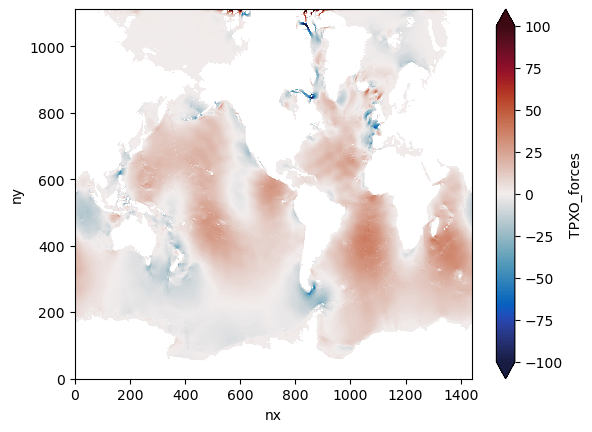

In [17]:
energy_w = xr.open_dataset('/g/data/nm03/lxy581/tpxo9v5a/TPXO_M2_W.nc')
W = energy_w["TPXO_forces"]
W.plot(vmin=-100,vmax=100,cmap=cm.cm.balance)

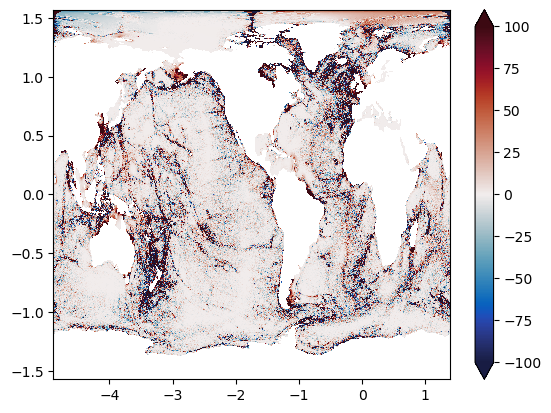

In [18]:
# D = W - P
D = np.array(W) - P
pcm = plt.pcolormesh(lon_z, lat_z, D, cmap=cm.cm.balance, vmin=-100, vmax=100)#norm=LogNorm(vmin=1e-3, vmax=1e+3))
cb1 = plt.colorbar(pcm, orientation='vertical', extend='both')

In [19]:
TPXO_forces   = np.array(W) 
global_forces = np.nansum(TPXO_forces*area_025) /1e+12 /1e+3
print('Global M2 tidal energy generation: %.2f TW '%global_forces)

global_fluxes = np.nansum(P*area_025) /1e+12 /1e+3
print('Global M2 tidal energy flux div: %.4f TW'%global_fluxes)

global_dissip = np.nansum(D*area_025) /1e+12 /1e+3
print('Global M2 tidal energy dissip: %.4f TW'%global_dissip)

deep_dissip = np.nansum(D*area_025*fac_dep_025) /1e+12 /1e+3
print('Global M2 tidal energy dissip (>1000m): %.4f TW'%deep_dissip)

print('Deep fraction: %.2f'%(deep_dissip/global_dissip))

Global M2 tidal energy generation: 2.61 TW 
Global M2 tidal energy flux div: -0.2040 TW
Global M2 tidal energy dissip: 2.7084 TW
Global M2 tidal energy dissip (>1000m): 0.9204 TW
Deep fraction: 0.34
